In [1]:
# Systems and paths
import sys
import os

In [2]:
data_path = "/import/tintagel3/snert/louis/photometry/data/PCA_data"
sys.path.append(data_path)

In [3]:
# from pupil_import import * # WARNING IMPORT NUMPY AS NP
from tqdm.notebook import tqdm

import jax
import jax.numpy as np
from jax.ops import index, index_update
import numpy as onp
import morphine as mp
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.ndimage import zoom
# from jax.config import config
# config.update("jax_enable_x64", True)

In [4]:
def zernkie_PSF(ampl, size=0, tf_size=2**12, npix=1024, pupil=None, zernike=None):
    c = tf_size//2
    s = npix//2

    # Add zernike to pupil
    if zernike is None:
        pupil_new = pupil
    else:
        Z = ampl * zernike
        pupil_new = np.abs(pupil) * np.exp((np.angle(pupil) + Z) * 1j)

    # Pad and TF
    arr = np.zeros([tf_size, tf_size], dtype=np.complex64)
    arr = index_update(arr, index[:size, :size], pupil_new)

    # TF, normalise, etc...
    wf = np.fft.fftshift(np.fft.fft2(arr))
    PSF = np.abs(wf)**2
    PSF_norm = PSF/np.sum(PSF)    
    PSF_out = PSF_norm[c-s:c+s, c-s:c+s]

    return PSF_out

def scale_pupil(pupil, output_size):
    """
    Takes in the complex pupil array and returns a scaled version
    
    BUGS: 
    This does not work correctly on pupils with the side lobe gratings
    
    Inputs:
        pupil: 2D Complex np array of the phase pupil
        output_size: Size of the pupil array to be returned
        
    Returns:
        pupil_scaled: 2D Complex np array of the pupil in the dimension of output_size X output_size
    """
    pupil = onp.array(pupil)
    
    # Scale the real component of the pupil to this size
    size_in = pupil.shape[0]
    ratio = float(output_size/size_in)
    Re_scaled = zoom(list(pupil.real), ratio)
    
    # Create the new pupil from a real and imaginary component
    pupil_scaled = Re_scaled + onp.zeros([output_size, output_size]) * 1j
    
    # Create the masks to fix the values of the pupil
    norm_phase = onp.logical_and(onp.abs(pupil_scaled) != 0, onp.angle(pupil_scaled) == 0)
    anti_phase = onp.logical_and(onp.abs(pupil_scaled) != 0, 
                                onp.logical_or(onp.angle(pupil_scaled) == onp.pi, onp.angle(pupil_scaled) == -onp.pi))
    c = output_size//2
    s = onp.linspace(-c, c, num=output_size, endpoint=False)
    X,Y = onp.meshgrid(s, s)
    R = onp.hypot(X,Y)
    
    # Assign the correct values to the new array
    pupil_scaled[norm_phase] = onp.complex(1, 0)
    pupil_scaled[anti_phase] = onp.complex(-1, 0)
    pupil_scaled[R >= c-1] = onp.complex(0, 0)
    
    return pupil_scaled

def pupil_from_fits(file_name):
    """
    Takes in the fits file and returns a complex array of the pupil
    """
    # Create a fits object from astropy
    fits_file = fits.open(file_name)[0].data
    array = onp.array(fits_file)

    # Calculate needed values
    gridsize = array.shape[0]
    c = gridsize//2
    
    # Create value arrays
    Xs = onp.linspace(-c, c-1, num=gridsize)
    X, Y = onp.meshgrid(Xs, Xs)
    r = onp.hypot(X, Y)
    
    # Create pupil
    pupil = onp.exp(1j*array)
    
    # Zero outer regions
    pupil[r >= (gridsize//2)] = onp.complex(0,0)
        
    return pupil

In [5]:
# Define simulation parameters
tf_size = 2**12
npix = tf_size
fl = 0.15
aperture = 0.018

In [6]:
# pix_size = 3e-7
pix_size = 1.12e-6 / 5

In [9]:
wl_min = 475e-9
wl_max = 625e-9
sizes_out = []
for wl in [wl_max, wl_min]:
    plate_scale = pix_size/fl    # Radians per pixel
    spatial_freq = wl/aperture
    scale_factor = spatial_freq/plate_scale
    sizes_out.append(tf_size/scale_factor)    
sizes = np.arange(int(np.round(sizes_out[0], decimals=0)), int(np.round(sizes_out[1], decimals=0)))
lams = tf_size*aperture*pix_size/(fl*sizes)
nlams = len(sizes)
wl_range = lams[0] - lams[-1]
print(sizes_out)
print(sizes)

# Uniform Spectra
spectra = np.ones(len(sizes))

[176.160768, 231.7904842105263]
[176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193
 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211
 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229
 230 231]


In [10]:
print(lams)

[6.2557086e-07 6.2203657e-07 6.1854200e-07 6.1508649e-07 6.1166929e-07
 6.0828989e-07 6.0494767e-07 6.0164194e-07 5.9837220e-07 5.9513769e-07
 5.9193803e-07 5.8877259e-07 5.8564086e-07 5.8254221e-07 5.7947619e-07
 5.7644229e-07 5.7343999e-07 5.7046879e-07 5.6752828e-07 5.6461784e-07
 5.6173712e-07 5.5888569e-07 5.5606301e-07 5.5326876e-07 5.5050236e-07
 5.4776359e-07 5.4505188e-07 5.4236688e-07 5.3970825e-07 5.3707549e-07
 5.3446831e-07 5.3188637e-07 5.2932921e-07 5.2679655e-07 5.2428800e-07
 5.2180320e-07 5.1934188e-07 5.1690364e-07 5.1448819e-07 5.1209526e-07
 5.0972443e-07 5.0737543e-07 5.0504809e-07 5.0274190e-07 5.0045674e-07
 4.9819221e-07 4.9594809e-07 4.9372414e-07 4.9151998e-07 4.8933549e-07
 4.8717027e-07 4.8502409e-07 4.8289684e-07 4.8078812e-07 4.7869776e-07
 4.7662544e-07]


In [11]:
print(len(lams))

56


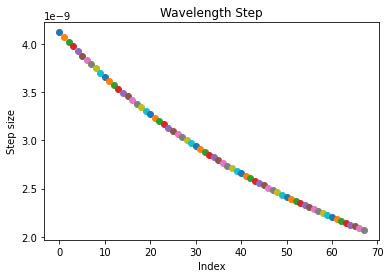

In [9]:
for i in range(len(lams)-1):
    plt.scatter(i, lams[i] - lams[i+1])
    
plt.title("Wavelength Step")
plt.ylabel("Step size")
plt.xlabel("Index")
plt.show()

In [10]:
# n_zern = 36
n_zern = 15
# n_zern = 10

pupil_files = os.listdir("{}/Pupils/".format(data_path))
zernike_files = os.listdir("{}/Zernike_sets/".format(data_path))

In [11]:
# pupil0 = np.load("{}/Pupils/{}.npy".format(data_path, sizes[0]))
# PSF0 = zernkie_PSF(0., npix=npix, tf_size=tf_size, size=sizes[0], pupil=pupil0)

# pupil1 = np.load("{}/Pupils/{}.npy".format(data_path, sizes[-1]))
# PSF1 = zernkie_PSF(0., npix=npix, tf_size=tf_size, size=sizes[-1], pupil=pupil1)

In [12]:
# c = npix//2
# s = 512

# plt.figure(figsize=(10, 4))

# plt.subplot(1, 2, 1)
# plt.imshow(PSF0[c-s:c+s, c-s:c+s])
# plt.colorbar()

# plt.subplot(1, 2, 2)
# plt.imshow(PSF1[c-s:c+s, c-s:c+s])
# plt.colorbar()

# plt.show()

In [13]:
# file_settings = "plot_test"
file_settings = "475_675_5"

In [15]:
for i in tqdm(range(len(sizes))):
    if "{}.npy".format(sizes[i]) in pupil_files:
        pupil = np.load("{}/Pupils/{}.npy".format(data_path, sizes[i]))
    else:
        pupil_in = pupil_from_fits("pupil.fits")
        pupil = scale_pupil(pupil_in, sizes[i])
        np.save("{}/Pupils/{}.npy".format(data_path, sizes[i]), pupil)

    if "{}.npy".format(sizes[i]) in zernike_files:
        zernikes = np.load("{}/Zernike_sets/{}.npy".format(data_path, sizes[i]))
    else:
        zernikes_in = mp.zernike.zernike_basis(n_zern, npix=sizes[i], outside=0.0)
        zernikes = np.array([z/np.sum(z**2) for z in zernikes_in])
        np.save("{}/Zernike_sets/{}.npy".format(data_path, sizes[i]), zernikes)

        # Generate PSF
        PSF = zernkie_PSF(0., size=sizes[i], npix=npix, tf_size=tf_size, zernike=zernikes[0], pupil=pupil)
        np.save("{}/PCA_data/{}/{}_PSF.npy".format(data_path, file_settings, sizes[i]), PSF)

    # Generate PSF gradients
    for j in tqdm(range(n_zern), leave=False):
        if "{}_{}.npy".format(sizes[i], j) in os.listdir("{}/PCA_data/{}/".format(data_path, file_settings)):
            pass
        else:
            J = jax.jacfwd(zernkie_PSF)(0., size=sizes[i], npix=npix, tf_size=tf_size, zernike=zernikes[j], pupil=pupil)
            np.save("{}/PCA_data/{}/{}_{}.npy".format(data_path, file_settings, sizes[i], j), J)